# 0. Imports and Data Loading

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

In [2]:
url = "https://raw.githubusercontent.com/Ale42RA/SWAN/main/swan.xlsx" 
swan = pd.read_excel(url, engine="openpyxl")  

# 1. Exploratory Data Analysis 🕵

## a. General Exploration 

### Dataframe Exploration  

In [6]:
# Check the shape of the data
print("\nShape:\n", swan.shape)
swan.shape

# Check the columns
print("\nColumns:\n", swan.columns)


Shape:
 (7043, 31)

Columns:
 Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Reason'],
      dtype='object')


In [7]:
# Check for null values
print("Columns where there are null values:")
null_values = swan.isnull().sum()
print(null_values[null_values > 0])

# Check for empty strings
print("\nColumns where there are "" or " " values:")
empty_strings = ((swan == " ") | (swan == "")).sum()
print(empty_strings[empty_strings > 0])

Columns where there are null values:
Churn Reason    5174
dtype: int64

Columns where there are  or  values:
Total Charges    11
dtype: int64


In [8]:
# Check for duplicate data, if the shape of the mask produced is bigger than 0 it indicates we have duplicates
# Otherwise no duplicates. 
print("There are no duplicates:", swan[swan.duplicated()].shape[0] == 0)


There are no duplicates: True


### Data Type/Uniqueness Exploration  

In [10]:
# Count unique values for each column
print("\nUnique Values Per Column:")
swan.nunique()


Unique Values Per Column:


CustomerID           7043
Count                   1
Country                 1
State                   1
City                 1129
Zip Code             1652
Lat Long             1652
Latitude             1652
Longitude            1651
Gender                  2
Senior Citizen          2
Partner                 2
Dependents              2
Tenure Months          73
Phone Service           2
Multiple Lines          3
Internet Service        3
Online Security         3
Online Backup           3
Device Protection       3
Tech Support            3
Streaming TV            3
Streaming Movies        3
Contract                3
Paperless Billing       2
Payment Method          4
Monthly Charges      1585
Total Charges        6531
Churn Label             2
Churn Value             2
Churn Reason           20
dtype: int64

In [11]:
# Check the types of data in the dataframe
swan.dtypes

CustomerID            object
Count                  int64
Country               object
State                 object
City                  object
Zip Code               int64
Lat Long              object
Latitude             float64
Longitude            float64
Gender                object
Senior Citizen        object
Partner               object
Dependents            object
Tenure Months          int64
Phone Service         object
Multiple Lines        object
Internet Service      object
Online Security       object
Online Backup         object
Device Protection     object
Tech Support          object
Streaming TV          object
Streaming Movies      object
Contract              object
Paperless Billing     object
Payment Method        object
Monthly Charges      float64
Total Charges         object
Churn Label           object
Churn Value            int64
Churn Reason          object
dtype: object

Exploring the repetition of 1652 for Zip Code and Coordinate Columns 

In [13]:
# Group by the zipcode and aggregate on nunique. 
# This will produce a table that accounts for each ZipCode, what is the unique count for Lat, Long and Lat Long 
#          Lat Long  Latitude  Longitude
# Zip Code                               
#   X            1         1          1
#   X            1         1          1
unique_locations = swan.groupby('Zip Code').agg({
    'Lat Long': 'nunique',
    'Latitude': 'nunique',
    'Longitude': 'nunique'
})


# Filter groups where there are inconsistencies
inconsistent_groups = unique_locations[(unique_locations['Lat Long'] > 1) | 
                                                          (unique_locations['Latitude'] > 1) | 
                                                          (unique_locations['Longitude'] > 1)]

print("Any inconsistent for Coordinate information:", inconsistent_groups.shape[0] > 0)

Any inconsistent for Coordinate information: False


In [14]:
# Make sure data between Churn Value and Churn Reason and Churn Label is consistent 

check1= swan[(swan['Churn Value'] == 0) & (swan['Churn Reason'].notnull())]  #get the rows of someone that has not churned and has something written as reason
check2 = swan[(swan['Churn Value'] == 1) & (swan['Churn Reason'].isnull())] #get the rows of someone that has churned and has no reason listed
check3= swan[(swan['Churn Value'] == 1) & (swan['Churn Label'] == "No")]  #get the rows of someone that has churned but has churned label as no
check4= swan[(swan['Churn Value'] == 0) & (swan['Churn Label'] == "Yes")] #get the rows of someone that has not churned but has churned label as yes

print("Not churned match no churn reason: ", check1.shape[0] == 0 )
print("Churned match has a churn reason: ", check2.shape[0] == 0 )
print("Not churned value matches no churn label: ", check3.shape[0] == 0 )
print("Churned value matches churn label: ", check4.shape[0] == 0 )


Not churned match no churn reason:  True
Churned match has a churn reason:  True
Not churned value matches no churn label:  True
Churned value matches churn label:  True


## b. Findings 🔎 


### Dataframe Exploration


 


- 7043 records with 31 columns
- Null values
    - Churn Reason 5174 --> Due to the customer NOT churning. 
- Empty Values ("" or " "): 
    - Total Charges  --> 11

### Feature engineering checklist: 


- Columns to Drop:
    - Records with a ZipCode, will share Lat and Long and Lat Long. The data is redundant
    - Count, Country, State share no new data (uniqueness of 1)
    
- Mapping
    - 'Gender',
    - 'Senior Citizen',
    - 'Partner',
    - 'Dependents',
    - 'Phone Service',
    - 'Multiple Lines',
    - 'Internet Service',
    - 'Online Security',
    - 'Online Backup',
    - 'Device Protection',
    - 'Tech Support',
    -  Streaming TV',
    - 'Streaming Movies',
    - 'Contract',
    - 'Paperless Billing',
    - 'Payment Method',
    
- Target
    - 'Churn Value'
    - 'Churn Reason' : Drop (Does not help in predicting)
    - 'Churn Label'Drop (Does not help in predicting) 

- Consider Drop:
    - 'City'
- Cast to float (Currently there are Null values that make it not possibe) 
- 'Total Charges'

## c. Train Splitting 🖖
For a more indepth analysis where we look at the numbers, we want to split first to avoid any biases.

In [22]:
# We ignore all other plausible targets and only consider Churn Value. 
# This is beacuse it is already numerical
target = 'Churn Value' 
feature_col = swan.columns
feature_col = feature_col.drop([target])

# Section prediction and features
X = swan[feature_col]
y = swan[target]

# 70/30 split to prevent overfitting and we can have a better understanding when running test 
# Stratify to make sure we have a good variety of churns 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12, stratify=y, )

# Since this plot is for EDA we reattach Churn Value to our df
swan_train = pd.concat([X_train, y_train], axis=1)

# We will be working in tableau so we want a sample of our train split to upload
swan_train.to_csv('swan_train.csv', index=False)

## d. Understanding the Data 📊


- Locators
    - 'City', 'Zip Code'
- Payments and Contracts 
    - 'Tenure Months', 'Contract', 'Monthly Charges', 'Total Charges'
- Explanation
    - 'Churn Reason'  
- Binary Normalised churners:
    - 'Gender', 'Senior Citizen', 'Partner', 'Dependents',
    - 'Paperless Billing,  'Payment Method',  'Contract'
- Products
    - 'Phone Service', 'Multiple Lines',  'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV','Streaming Movies'

### Demographics

#### Churned Vs Non Churned -- Initial Analysis 

This was initially done to understand what to expect, however a better idea came up to use tableu later on. This is just to get some initial expectations on the data. 

In [27]:
# Select the demographic columns for churning 
demographic_columns = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Paperless Billing' ,'Payment Method',  'Contract' ]


In [28]:
# Function we can call recursiveley 
def plot_bar_charts(churn_group, non_churn_group, column):

    #normalise the churn count for each demographic column 
    churn_distribution = churn_group[column].value_counts(normalize=True) * 100
    non_churn_distribution = non_churn_group[column].value_counts(normalize=True) * 100

    # combine into dataframe for plotting
    #format: id            category           churned          not churned
    #          int         obj                  float               float 
    data = pd.DataFrame({
        'Category': churn_distribution.index,
        'Churned': churn_distribution.values,
        'Not Churned': non_churn_distribution.values
    })
    print(data)

    # flip the formatting so we can get 4 bars (2 category and each category having a churned and not churned)
    #format: id            category           variable              value
    #        int             obj            churned/not churned       float 
    bar_data = pd.melt(
        data, 
        id_vars='Category', 
        value_vars=['Churned', 'Not Churned'])
    bar_data.columns = ['Category', 'Churn status', 'Normalized percentage']
    print(bar_data)

    # plot bar chart
    plt.figure(figsize=(8, 6))
    sns.barplot(
        x='Category', 
        y='Normalized percentage', 
        hue='Churn status', 
        data=bar_data, 
    )
    plt.title(f'{column} Distribution by Churn Status')
    plt.ylabel('Percentage (%)')
    plt.xlabel(column)
    plt.legend(title='Churn Status', loc='upper right')
    plt.show()


  Category    Churned  Not Churned
0     Male  50.458716     50.88349
1   Female  49.541284     49.11651
  Category Churn status  Normalized percentage
0     Male      Churned              50.458716
1   Female      Churned              49.541284
2     Male  Not Churned              50.883490
3   Female  Not Churned              49.116510


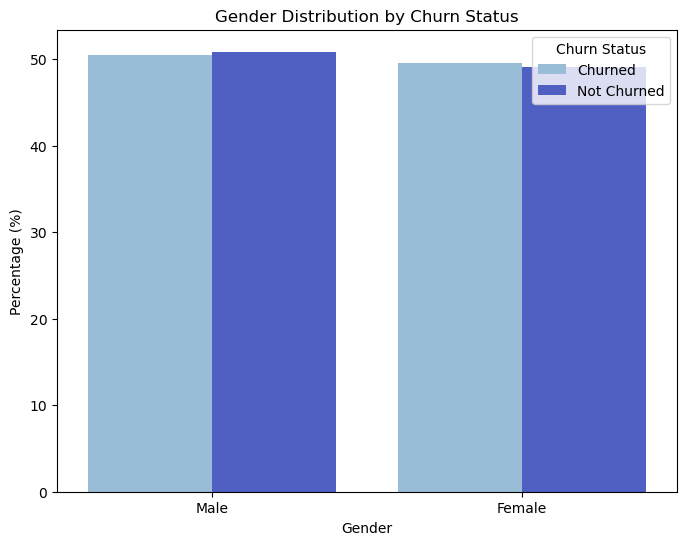

  Category    Churned  Not Churned
0       No  73.853211    86.968526
1      Yes  26.146789    13.031474
  Category Churn status  Normalized percentage
0       No      Churned              73.853211
1      Yes      Churned              26.146789
2       No  Not Churned              86.968526
3      Yes  Not Churned              13.031474


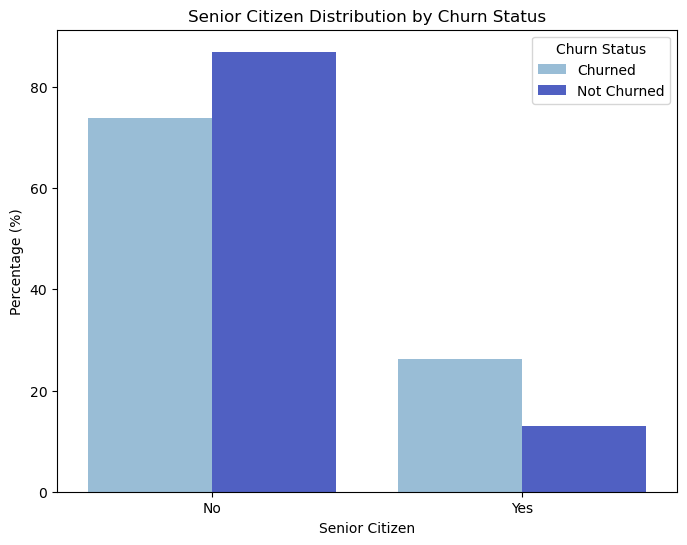

  Category    Churned  Not Churned
0       No  64.908257    52.429597
1      Yes  35.091743    47.570403
  Category Churn status  Normalized percentage
0       No      Churned              64.908257
1      Yes      Churned              35.091743
2       No  Not Churned              52.429597
3      Yes  Not Churned              47.570403


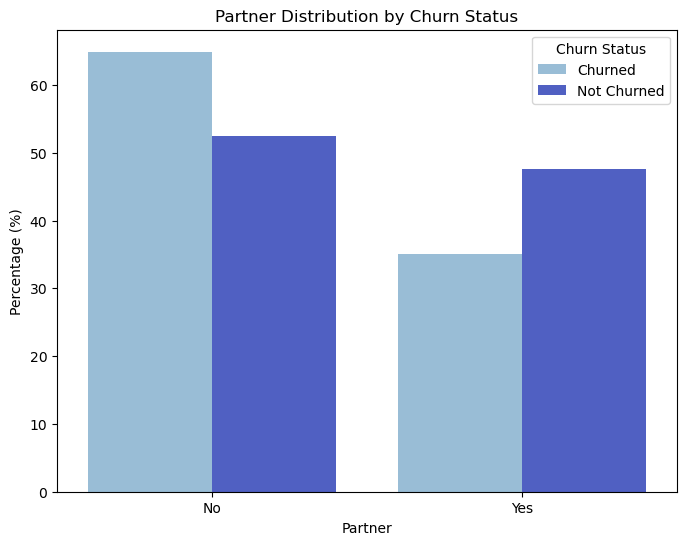

  Category    Churned  Not Churned
0       No  94.571865    70.651574
1      Yes   5.428135    29.348426
  Category Churn status  Normalized percentage
0       No      Churned              94.571865
1      Yes      Churned               5.428135
2       No  Not Churned              70.651574
3      Yes  Not Churned              29.348426


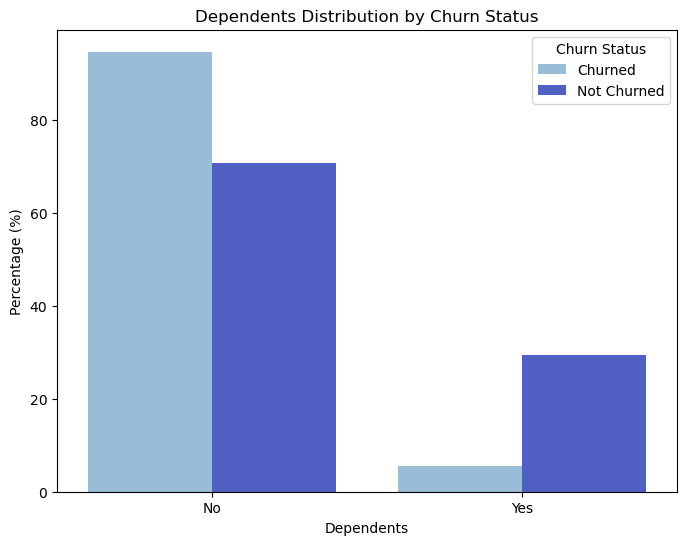

  Category   Churned  Not Churned
0      Yes  74.69419    53.119823
1       No  25.30581    46.880177
  Category Churn status  Normalized percentage
0      Yes      Churned              74.694190
1       No      Churned              25.305810
2      Yes  Not Churned              53.119823
3       No  Not Churned              46.880177


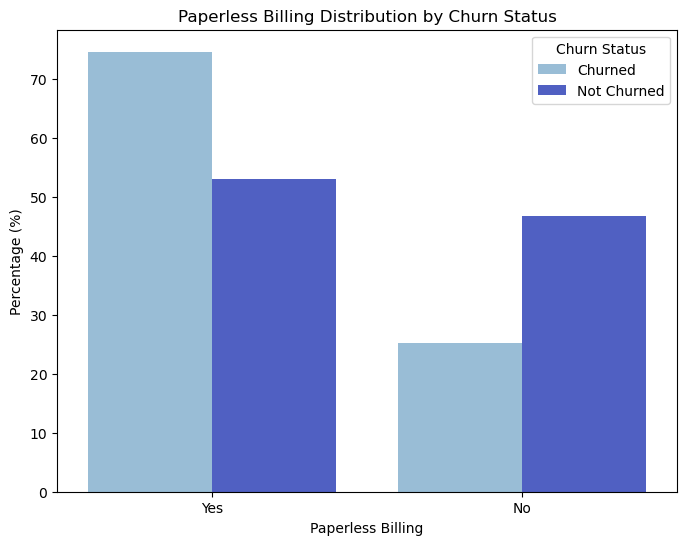

                    Category    Churned  Not Churned
0           Electronic check  57.645260    25.538377
1               Mailed check  15.825688    25.510768
2  Bank transfer (automatic)  14.067278    24.848150
3    Credit card (automatic)  12.461774    24.102706
                    Category Churn status  Normalized percentage
0           Electronic check      Churned              57.645260
1               Mailed check      Churned              15.825688
2  Bank transfer (automatic)      Churned              14.067278
3    Credit card (automatic)      Churned              12.461774
4           Electronic check  Not Churned              25.538377
5               Mailed check  Not Churned              25.510768
6  Bank transfer (automatic)  Not Churned              24.848150
7    Credit card (automatic)  Not Churned              24.102706


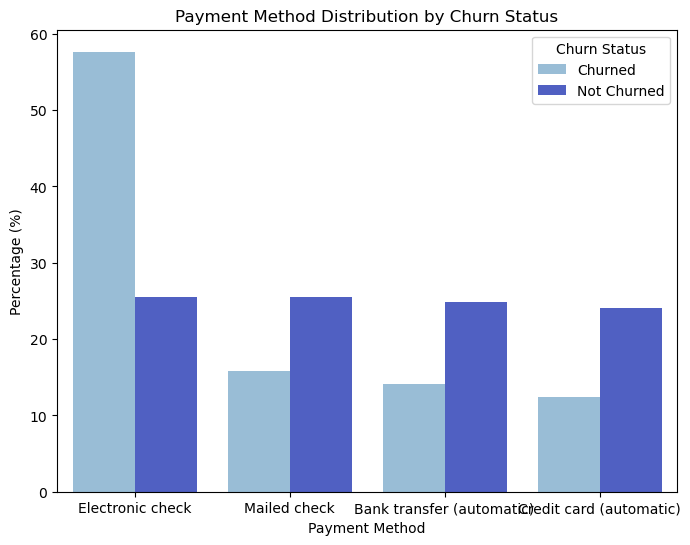

         Category    Churned  Not Churned
0  Month-to-month  87.920489    43.318609
1        One year   9.480122    31.722805
2        Two year   2.599388    24.958586
         Category Churn status  Normalized percentage
0  Month-to-month      Churned              87.920489
1        One year      Churned               9.480122
2        Two year      Churned               2.599388
3  Month-to-month  Not Churned              43.318609
4        One year  Not Churned              31.722805
5        Two year  Not Churned              24.958586


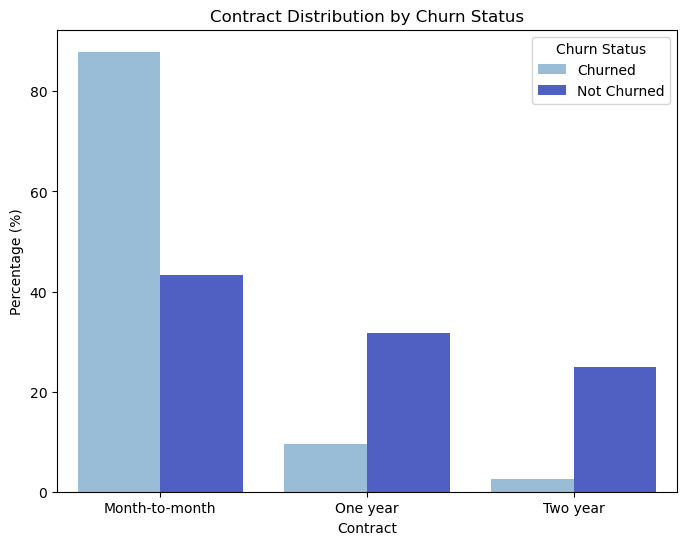

In [35]:
churners = swan_train[swan_train['Churn Value'] == 1]
non_churners = swan_train[swan_train['Churn Value'] == 0]

# Set colour palette in company colours
custom_palette = ['#8FBFE0','#3D52D5', '#6F584B', '#03012C'] 
sns.set_palette(sns.color_palette(custom_palette))

# Loop through each demographic column and plot bar charts
for column in demographic_columns:
    plot_bar_charts(churners, non_churners, column)

#### Tableau! 

- We want to create a table that selects what category something falls under, and what value that category was assigned. This is so in Tableau we can better work with **average expectations of a category**. 
    - e.g. If I am just looking at gender, it has a churn rate 0.25
- However we want to know how each individual gender fairs against this expected categorical average? Are they bringing it down or up
    - e.g. Male churn rate is 0.33 (Higher than average)
- For that we collect the values in a table that will look like this:

<table border="1">
  <tr>
    <th>CustomerID</th>
    <th>Churn Value</th>
    <th>Demographic Category</th>
    <th>Demographic Value</th>
  </tr>
  <tr>
    <td>x1</td>
    <td>0</td>
    <td>Gender</td>
    <td>Female</td>
  </tr>
  <tr>
    <td>x2</td>
    <td>0</td>
    <td>Senion Citizen</td>
    <td>Yes</td>
  </tr>
  <tr>
    <td>x3</td>
    <td>0</td>
    <td>Gender</td>
    <td>Female</td>
  </tr>
  <tr>
    <td>x4</td>
    <td>1</td>
    <td>Gender</td>
    <td>Female</td>
  </tr>
</table>

In [42]:
# Melt the demographic columns
demographic_mega_table = pd.melt(
                                swan_train, #using our split data
                                 id_vars=['CustomerID', 'Churn Value'], #we want to keep and look at CustomerID and Churn Value
                                 value_vars= demographic_columns, #values are the swan_train columns i,e. Gender
                                 var_name='Demographic Category', #How the column containing the swan_train columns
                                 value_name='Demographic Value' #The column name for the actual value will be Demograohic value
                                )

# Save for use in tableau
demographic_mega_table.to_csv('demographic_mega_table.csv', index=False)
demographic_mega_table.head()

,CustomerID,Churn Value,Demographic Category,Demographic Value
0,7296-PIXQY,0,Gender,Female
1,3981-QSVQI,0,Gender,Male
2,0458-HEUZG,0,Gender,Female
3,5550-VFRLC,1,Gender,Female
4,0929-HYQEW,0,Gender,Male


### Exploring Month 

<div style="display: flex;">
    <div style="flex: 1; text-align: center;">
        <div style="width: 100%; height: 100%">
            <img src="https://raw.githubusercontent.com/Ale42RA/SWAN/main/img/Monthly_Charges_Services.png" 
             alt="Monthly Charges" style="max-width: 120%; height: auto; border: 1px solid #ccc;">
        </div>
    </div>
    <div style="flex: 1; text-align: center;">
        <img src="https://raw.githubusercontent.com/Ale42RA/SWAN/main/img/Monthly_Charges.png" 
             alt="Monthly Charges" style="max-width: 100%; ">
    </div>
</div>
Customers that spend more on monthly charges generally have a higher churn rate.

However, customers that spend more than $100 per month have a significantly lower churn rate.

These customers almost exclusively use Swan Teleco for streaming movies.


### Exploring Tenure and Churn 

![Tenure vs Churn Rate](https://raw.githubusercontent.com/Ale42RA/SWAN/main/img/Tenure%20Month.png)

As customer tenure increases, the churn rate decreases. This trend suggests that longer-tenured customers exhibit greater commitment and loyalty, reducing the likelihood of churn over time.

### Exploring Reasons For Churning 

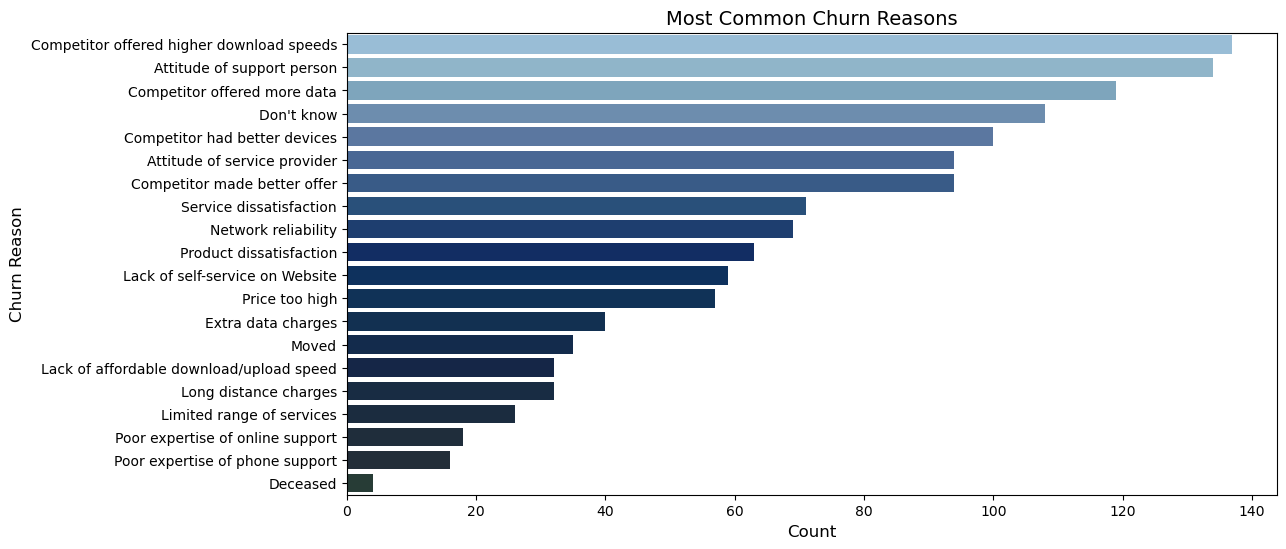

In [50]:
# define custom palette with more hex values
custom_palette_gradient = [
            '#8FBFE0', '#86B8D3', '#74A8C6', '#628DB9', '#4F75AC', 
            '#3D64A0', '#2C5A94', '#1B5088', '#103B7D', '#042871',
            '#01306A', '#043263', '#07305C', '#0A2A55', '#0D244F',
            '#112B4A', '#152C45', '#1A2D40', '#1F2E3C', '#243F37'
]

# ensure the palette has the exact number of unique churn reasons
palette_zip = zip(churners['Churn Reason'].value_counts().index, custom_palette_gradient)


plt.figure(figsize=(12, 6))
sns.countplot(
    data=churners, 
    y='Churn Reason', 
    order=churners['Churn Reason'].value_counts().index,
    palette=dict(palette_zip),
    legend=False,
    hue = 'Churn Reason'
)
plt.title('Most Common Churn Reasons', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Churn Reason', fontsize=12)
plt.show()

### Products 

#### Initial Assesment 

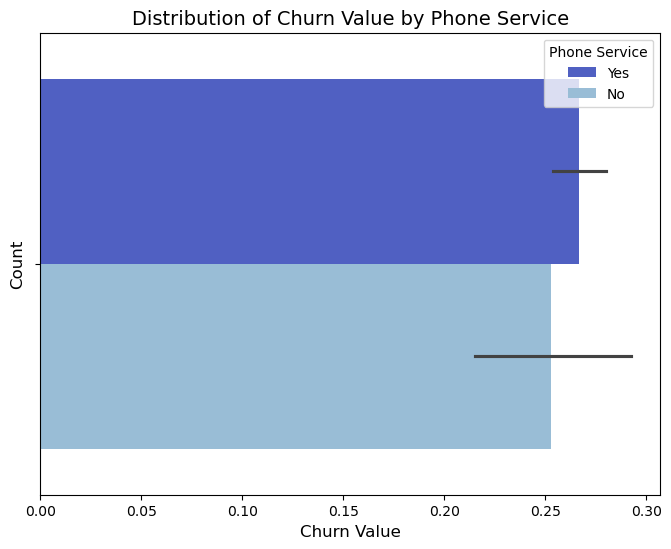

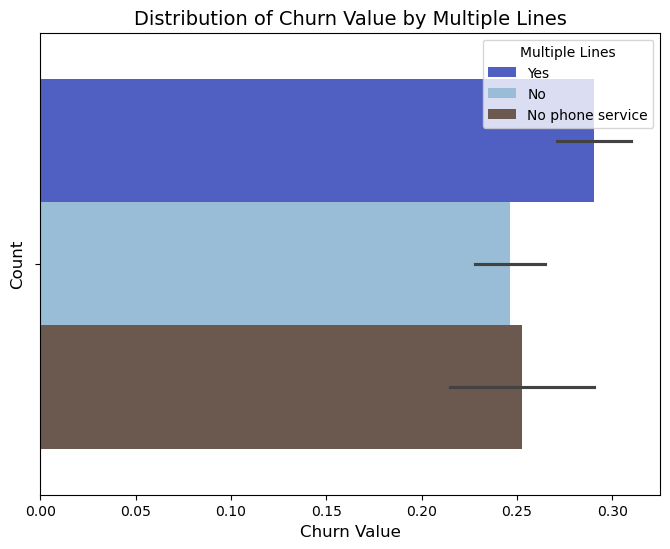

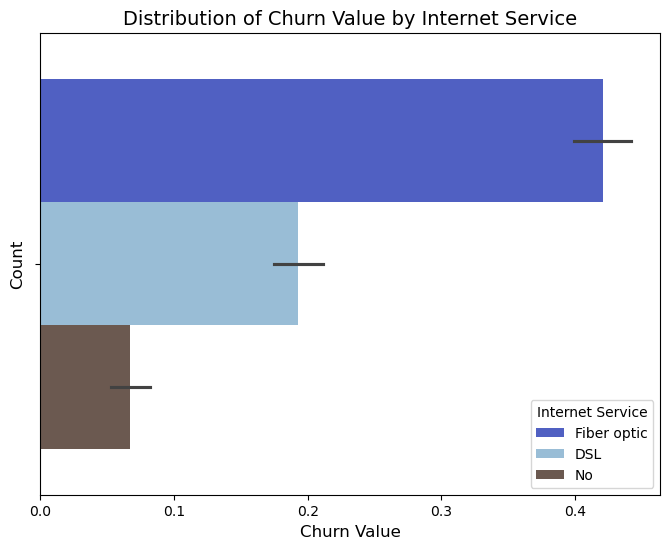

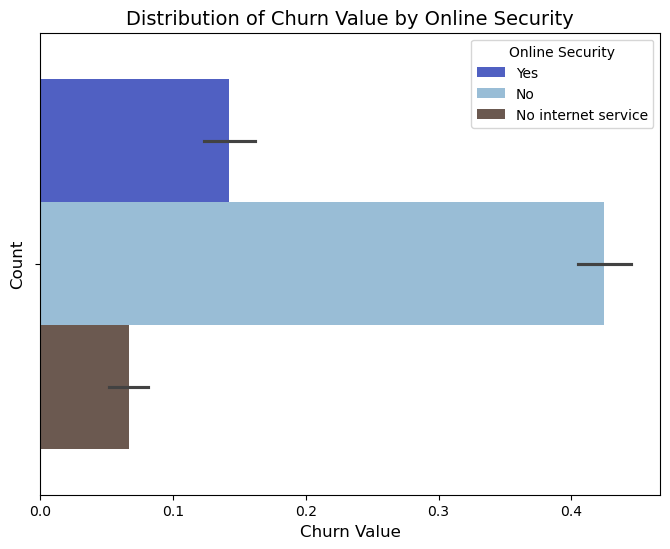

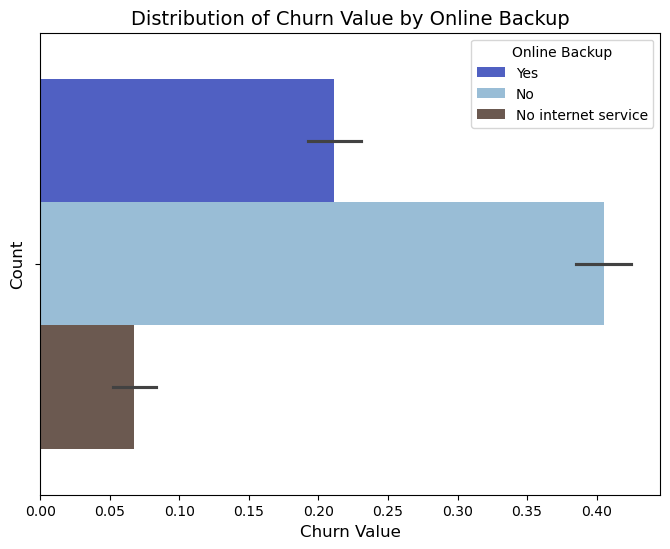

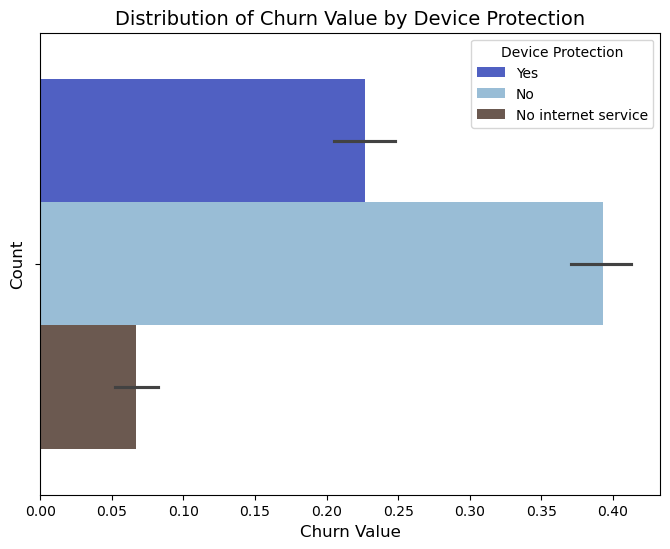

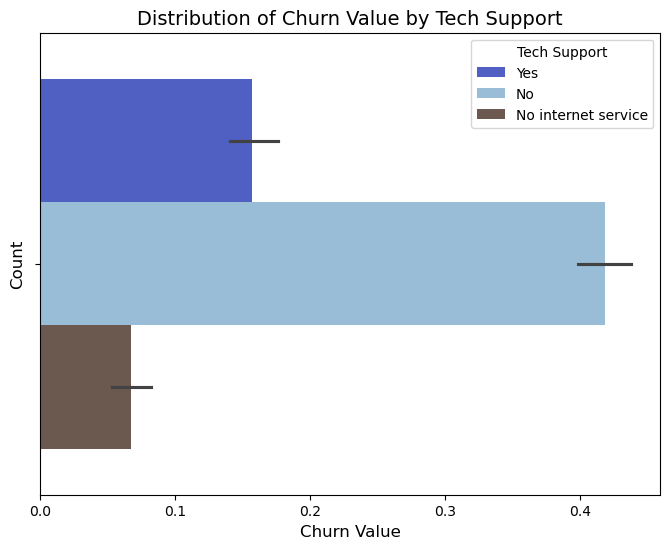

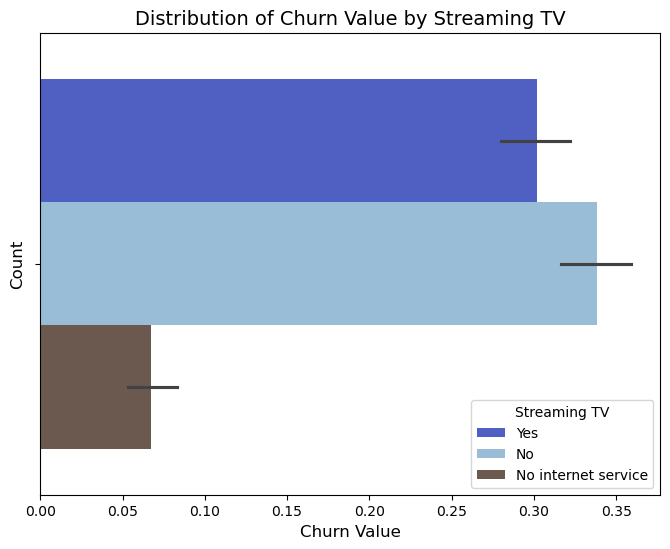

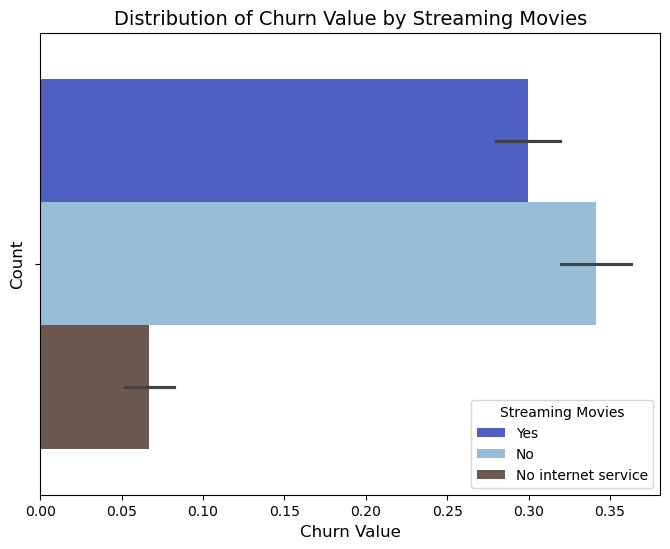

In [60]:
# Mask for the products 
swan_train_products = swan_train[['Phone Service', 'Multiple Lines', 
                            'Internet Service', 'Online Security', 'Online Backup', 
                            'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies','Churn Value']]

# Set colour palette in company colours
custom_palette = ['#3D52D5', '#8FBFE0','#6F584B','#EFF1ED', '#03012C'] 
sns.set_palette(sns.color_palette(custom_palette))

# Do a bar plot for each comparing churn value
for col in swan_train_products:
    if col in ['Online Security','Online Backup','Device Protection','Tech Support','Streaming TV','Streaming Movies']:
        plt.figure(figsize=(8, 6))
        sns.barplot(data=swan_train_products, x='Churn Value', hue = col, hue_order = ['Yes','No','No internet service'])
        plt.ylabel('Count', fontsize=12)
        plt.xlabel('Churn Value', fontsize=12)
        plt.title(f'Distribution of Churn Value by {col}', fontsize=14)
        plt.show()
    elif col == 'Phone Service':
        plt.figure(figsize=(8, 6))
        sns.barplot(data=swan_train_products, x='Churn Value', hue = col)
        plt.ylabel('Count', fontsize=12)
        plt.xlabel('Churn Value', fontsize=12)
        plt.title(f'Distribution of Churn Value by {col}', fontsize=14)
        plt.show()
    elif col == 'Multiple Lines':
        plt.figure(figsize=(8, 6))
        sns.barplot(data=swan_train_products, x='Churn Value', hue = col, hue_order = ['Yes','No','No phone service'])
        plt.ylabel('Count', fontsize=12)
        plt.xlabel('Churn Value', fontsize=12)
        plt.title(f'Distribution of Churn Value by {col}', fontsize=14)
        plt.show()
    elif col == 'Internet Service':
        plt.figure(figsize=(8, 6))
        sns.barplot(data=swan_train_products, x='Churn Value', hue = col, hue_order = ['Fiber optic','DSL','No'])
        plt.ylabel('Count', fontsize=12)
        plt.xlabel('Churn Value', fontsize=12)
        plt.title(f'Distribution of Churn Value by {col}', fontsize=14)
        plt.show()   

#### Tableau! 

In [62]:
product_columns = ['Device Protection', 'Internet Service', 'Multiple Lines', 'Online Backup', 'Online Security', 
                   'Phone Service','Streaming Movies', 'Streaming TV', 'Tech Support']

# Melt the demographic columns
mega_products_table = pd.melt(swan_train, 
                     id_vars=['CustomerID', 'Churn Value'], 
                     value_vars= product_columns,
                     var_name='Product Category',
                     value_name='Product Value')

# Pivoted_df
mega_products_table.to_csv('mega_products_table.csv', index=False)
mega_products_table.head()

,CustomerID,Churn Value,Product Category,Product Value
0,7296-PIXQY,0,Device Protection,No
1,3981-QSVQI,0,Device Protection,No internet service
2,0458-HEUZG,0,Device Protection,Yes
3,5550-VFRLC,1,Device Protection,No
4,0929-HYQEW,0,Device Protection,No


## Resources 

Tables and CSVs in Github 

https://github.com/Ale42RA/SWAN


# 2. Data Split 🖖

In [66]:
# We ignore all other plausible targets and only consider Churn Value. 
# This is beacuse it is already numerical
target = 'Churn Value' 
feature_col = swan.columns
feature_col = feature_col.drop([target, 'Churn Label', 'Churn Reason'])

# Section prediction and features
X = swan[feature_col]
y = swan[target]


# 70/30 split to prevent overfitting and we can have a better understanding when running test 
# stratify on your to make sure we have a good variety of churns 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=12, stratify=y, )

In [68]:
#Check that the split has been correctly proportionally handled (70/30)
print(f' Shape X_train: {X_train.shape}           Shape X_test {X_test.shape}')
print(f' Shape y_train: {y_train.shape}             Shape y_test {y_test.shape}')

#Check that all indexing is corrent in Train and Test 
print(f'Indexing on train is [{all(X_train.index == y_train.index)}]         on test is [{all(X_test.index == y_test.index)}] ')

 Shape X_train: (4930, 28)           Shape X_test (2113, 28)
 Shape y_train: (4930,)             Shape y_test (2113,)
Indexing on train is [True]         on test is [True] 


# 3. Feature Engineering ⚙️

From our EDA, we determined the following data preparation steps were necessary:  
- Dropped `Customer ID` to ensure the model generalises properly.  
- Dropped columns such as `Count`, `Country`, and `State`, as these were identical across all observations and would not contribute to the model.  
- Dropped `City` due to its high uniqueness, making it unsuitable for one-hot encoding or mapping.  
- Dropped `Zip Code`, `Lat Long`, `Latitude`, and `Longitude`, as we determined these features were not useful for the model.  
- Mapped non-numerical columns to numerical values for compatibility with the model.  
- Dropped `Churn Reason` and `Churn Label`, as they were too closely related to the target variable.  

In [72]:
def feature_eng(df):
    df.copy()
    feature_columns = [ 
        'Gender', 
        'Senior Citizen',
        'Partner',
        'Dependents', 
        'Tenure Months', 
        'Phone Service',
        'Multiple Lines', 
        'Internet Service', 
        'Online Security',
        'Online Backup', 
        'Device Protection', 
        'Tech Support', 
        'Streaming TV',
        'Streaming Movies', 
        'Contract', 
        'Paperless Billing', 
        'Payment Method',
        'Monthly Charges', 
        'Total Charges'
    ]
    
    df = df[feature_columns].copy()
    
    
    #Map columns that have a Yes/No category
    for col in [ 'Senior Citizen','Partner','Dependents', 'Phone Service', 'Paperless Billing']: 
        df[col] = df[col].map({'Yes': 1, 'No': 0, 1:1, 0:0})

    #Map column products that have a Yes/No/No interner service category
    for col in ['Device Protection', 'Online Backup', 'Online Security', 'Streaming Movies', 
                'Streaming TV', 'Tech Support']:
        df[col] = df[col].map({'Yes': 1, 'No': 0, 'No internet service': 2, 1:1, 0:0, 2:2})

    #Unique mapping required 
    df['Gender'] = df['Gender'].map({'Male': 1, 'Female': 0, 1:1, 0:0})
    df['Multiple Lines'] = df['Multiple Lines'].map({'Yes': 1, 'No': 0, 'No phone service':2, 1:1, 0:0, 2:2})
    df['Internet Service'] = df['Internet Service'].map({'Fiber optic':1, 'No':0, 'DSL':2, 1:1, 0:0, 2:2})
    df['Contract'] = df['Contract'].map({'Month-to-month': 0, 'Two year': 1, 'One year':2,1:1, 0:0, 2:2})  
    df['Payment Method'] = df['Payment Method'].map({'Mailed check': 0, 'Electronic check': 1, 'Bank transfer (automatic)':2, 'Credit card (automatic)':3, 1:1, 0:0, 2:2, 3:3})
   
    #cast total charges to numeris, the " " will turn to NaN
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce') 

    #in case of null (such as " " emppty string)
    df.dropna(inplace=True)
    
    
    return df


In [74]:
X_train_fe = feature_eng(X_train)
y_train = y_train.reindex(X_train_fe.index)

X_test_fe = feature_eng(X_test)
y_test = y_test.reindex(X_test.index)

## Quality Checks 

In [77]:
X_train_fe.dtypes

Gender                 int64
Senior Citizen         int64
Partner                int64
Dependents             int64
Tenure Months          int64
Phone Service          int64
Multiple Lines         int64
Internet Service       int64
Online Security        int64
Online Backup          int64
Device Protection      int64
Tech Support           int64
Streaming TV           int64
Streaming Movies       int64
Contract               int64
Paperless Billing      int64
Payment Method         int64
Monthly Charges      float64
Total Charges        float64
dtype: object

In [79]:
X_train_fe.shape

(4919, 19)

In [81]:
X_train_fe.isnull().sum()

Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
dtype: int64

In [83]:
print(f'Indexing on train is [{all(X_train_fe.index == y_train.index)}] ')
print(f'Indexing on test is [{all(X_test_fe.index == y_test.index)}] ')

Indexing on train is [True] 
Indexing on test is [True] 


# 4. Model 🤖

## a. Evaluate Function

In [87]:
# Function to calculate the metrics of quality for our trees. It will be called often.
def metrics_evaluate(X_train_fe, X_test_fe, y_train, y_test, tree):
     
    #########
    print("\n-------TRAIN --------\n")
    y_pred = tree.predict(X_train_fe)
    
    # Calculate accuracy
    accuracy_train = accuracy_score(y_train, y_pred)
    print("Accuracy: ", accuracy_train)
    
    # Calculate precision
    precision = precision_score(y_train, y_pred)
    print("Precision: ", precision)

    # Calculate recall
    recall = recall_score(y_train, y_pred)
    print("Recall: ", recall)
    
    # Calculate F1 score
    f1 = f1_score(y_train, y_pred)
    print("F1 Score: ", f1)

    #########
    print("\n-------TESTING --------\n")
    y_pred = tree.predict(X_test_fe)

    # Calculate accuracy
    accuracy_test = accuracy_score(y_test, y_pred)
    print("Accuracy: ", accuracy_test)
    
    # Calculate precision
    precision = precision_score(y_test, y_pred)
    print("Precision: ", precision)

    # Calculate recall
    recall = recall_score(y_test, y_pred)
    print("Recall: ", recall)
    
    # Calculate F1 score
    f1 = f1_score(y_test, y_pred)
    print("F1 Score: ", f1)
      

    # Calculate overfitfit percentage
    print("\n-------OVERFITTING PERCENTAGE--------\n")
    print(abs(accuracy_test - accuracy_train) * 100)


## b. Building our model 

We chose to use an **Extra Trees model** to reduce the risk of overfitting.  

In our approach, we prioritised precision while maintaining good overall accuracy. Minimising false positives was critical, as incorrectly predicting customer churn could result in costly incentives being sent to customers who were not at risk of leaving.


In [91]:
# Create empty extra tree classifier
et = ExtraTreesClassifier(n_estimators=50, random_state=12) 

In [93]:
# Parameters for grid search
et_params = {'n_estimators': [150, 160], 
               'max_depth': [5, 7,8]} 

In [95]:
# Grid search
gs_et = GridSearchCV(et, param_grid=et_params, cv=10)

In [97]:
# Fit our extra trees with grid search to the data
gs_et.fit(X_train_fe, y_train)

/opt/homebrew/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=10,
             estimator=ExtraTreesClassifier(n_estimators=50, random_state=12),
             param_grid={'max_depth': [5, 7, 8], 'n_estimators': [150, 160]})

In [98]:
# Determine best parameters found by grid search
gs_et.best_params_

{'max_depth': 8, 'n_estimators': 160}

In [99]:
# Retrieve the best parameters from the grid search and use them to create the final model.
# Fit the optimised model to the training data.
model = gs_et.best_estimator_
model.fit(X_train_fe, y_train)

ExtraTreesClassifier(max_depth=8, n_estimators=160, random_state=12)

In [105]:
import joblib

#joblib.dump(dt_et, 'model.pkl')
model = joblib.load('model.pkl')

## c. Results on Training and Testing Data

In [108]:
# Function for calculating accuracy, precision, recall and f1_score
metrics_evaluate(X_train_fe, X_test_fe, y_train, y_test, model)


-------TRAIN --------

Accuracy:  0.8147997560479773
Precision:  0.7027579162410623
Recall:  0.5259938837920489
F1 Score:  0.6016615653694797

-------TESTING --------

Accuracy:  0.8102224325603408
Precision:  0.6941747572815534
Recall:  0.5098039215686274
F1 Score:  0.5878725590955807

-------OVERFITTING PERCENTAGE--------

0.4577323487636509


<u>Our Model Metrics</u>

|Metrics | Training Data | Testing Data |
|--------| --------| --------| 
| Accuracy | 0.815 | 0.810 |
| Precision | 0.703 | 0.694 |
| Recall | 0.526 | 0.510 |
| F1 | 0.602 | 0.588 |

Since the accuracy of the testing data was within 1% of our training data, we were confident that our model was generalising well.  

While our recall is lower than we would have liked, we prioritised precision over recall and felt that this trade-off was acceptable.

# 5. Utlising our model 👾

In [113]:
# model loaded from pickle file, in a recurring notebook. 
# extraTreesClassifier(max_depth=7, n_estimators=160, random_state=12)

model_path = "model.pkl"
model = joblib.load(model_path)

## Feature Importance 🏆

#### Factors that influence someone churning.

To determine which feature to incentivise, we analysed the features with the most significant impact on our model and assessed how these factors influenced customer churn.

[View Feature Importance at risk on GitHub](https://raw.githubusercontent.com/Ale42RA/SWAN/refs/heads/main/feature_importance.csv)

In [118]:
# Determine the feature importance from our model
importance = list(zip(X_train_fe.columns, [round(x, 3) for x in model.feature_importances_]))

# Sort features into most important
importance_sorted = sorted(importance, key=lambda x: x[1], reverse=True)

# Create dataframe of feature importance
model_importance = pd.DataFrame(importance_sorted, columns=['Feature', 'Importance'])

model_importance.head()

,Feature,Importance
0,Contract,0.162
1,Tenure Months,0.148
2,Online Security,0.125
3,Dependents,0.106
4,Tech Support,0.092


In [120]:
# Save feature importance table as csv
model_importance.to_csv("feature_importance.csv", index=False)

#### Explaining the Top 3 Most Important Features

1. **Contract**  
The type of contract has a significant impact on the model. From our EDA, we observed that customers on a `two-year` contract were much less likely to churn compared to those on a `month-to-month` basis. This is expected, as customers on a two-year contract are often locked in and may face an additional exit fee, making them less likely to leave.

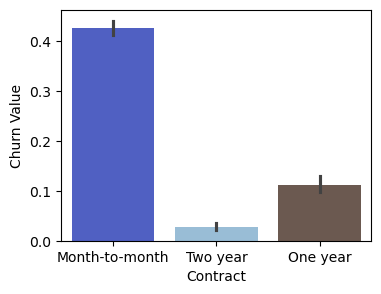

In [123]:
# Create barplot for contract vs churn value
plt.figure(figsize=(4, 3))
sns.barplot(swan, x='Contract', y ='Churn Value', hue ='Contract')
plt.show()

2. **Tenure Months**  
Similar to the contract feature, the longer a customer has stayed with the company, the less likely they are to churn. This is a common finding, as long-term customers tend to have a stronger relationship with the service.

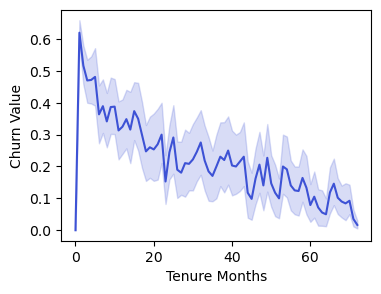

In [126]:
# Create lineplot for tenure months against churn value
plt.figure(figsize=(4, 3))
sns.lineplot(swan, x = 'Tenure Months', y = 'Churn Value', color = '#3D52D5')
plt.show()

3. **Online Security**  
Our EDA showed that online security has a significant effect on churn. Customers who did not have online security were much more likely to churn than those who were signed up for the service. This aligns with the model's findings, where online security was identified as a key factor influencing customer retention.

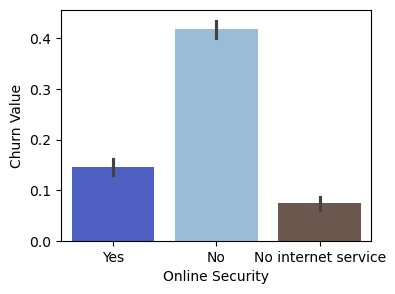

In [128]:
# Bar plot for online security
plt.figure(figsize=(4, 3))
sns.barplot(swan, x='Online Security', y ='Churn Value', hue = 'Online Security')
plt.show()

### Product to Incentivise

Since our focus was on incentivising a product rather than the top feature (contract type), we created a list of the most important products based on the feature importance rankings.

In [133]:
# Creating feature importance specifically for products
products = ['Online Security', 'Phone Service', 'Multiple Lines', 
            'Internet Service', 'Online Backup', 'Device Protection', 
            'Tech Support', 'Streaming TV', 'Streaming Movies']

product_importance = model_importance[model_importance['Feature'].isin(products)]

product_importance.head(3)

,Feature,Importance
2,Online Security,0.125
4,Tech Support,0.092
5,Internet Service,0.085


From the table, we can see that **online security** had the greatest impact on churn rate. Customers without online security typically exhibited higher churn rates, as shown in the graph above. Therefore, **incentivising** and encouraging users to sign up for this feature could be an effective strategy to reduce churn.

In [136]:
# Save product importance to csv
product_importance.to_csv("product_importance.csv", index=False)

## Top 500 non churned Customers 🥇
This section uses pre-trained ExtraTreesClassifier model to predict customer churn, rank customers by churn risk, and export the results.

[View top 500 at risk on GitHub](https://raw.githubusercontent.com/Ale42RA/SWAN/refs/heads/main/top_500.csv)

In [139]:
# prepare the main dataframe for prediction
swan_fe = feature_eng(swan)

In [141]:
probabilities = model.predict_proba(swan_fe) # predict likelihood of churn 
predicted = model.predict(swan_fe) # predict if the cutomer will churn 
swan_fe['Churn Risk'] = probabilities[:, 1] #from the array select the second column
swan_fe['Churn Prediction'] = predicted #attach predictions

In [143]:
swan_modelled = swan_fe.copy() #make a copy 

#include the 'CustomerID', 'Churn Value'(whether that have churned or not already) from the original dataframe, matching index on the swan_modelled datafram 
swan_modelled[['CustomerID', 'Churn Value']] = swan[['CustomerID', 'Churn Value']].reindex(swan_modelled.index) 

In [145]:
#filter for customers that have not yet churned 
#create a ranking by filtering on most likeley to churn first
swan_modelled = swan_modelled[swan_modelled['Churn Value'] == 0].sort_values(by ='Churn Risk', ascending = False)

In [147]:
top_500 = swan_modelled.head(500).reset_index(drop = True).copy()

In [149]:
top_500['Rank'] = top_500.index + 1
top_500 = top_500[['Rank','CustomerID','Churn Risk','Churn Prediction']]

In [151]:
top_500.to_csv('top_500.csv',index = False)

### Looking at the data 

The company offers a mailing list for those that are predicted to be at risk of churning, however 83 of the customers are not predicted to be at risk. 
The company expects a 20% uptake, which for the bottom cut of the 500, it would still greateley benefit since they are ~2% likelihood away from being predicted as churned. 

In [155]:
top_500[top_500['Churn Prediction'] == 0].shape[0]

83

In [157]:
top_500[top_500['Churn Prediction'] == 0].tail()

,Rank,CustomerID,Churn Risk,Churn Prediction
495,496,9793-WECQC,0.479426,0
496,497,6402-EJMWF,0.479403,0
497,498,0374-IOEGQ,0.479201,0
498,499,5968-VXZLG,0.479140,0
499,500,2277-VWCNI,0.478756,0


## Remaining Non Churned Customers 🥈

This section of code uses a pre-trained ExtraTreesClassifier model to predict customer churn, rank customers by churn risk, and export the results.

[View Remaining Non Churned Customers on GitHub](https://raw.githubusercontent.com/Ale42RA/SWAN/refs/heads/main/non_top_500.csv)

In [160]:
#Select from the index 500 (or 501th onwards)
#Only display the customer id, probability of churning and predicted value
non_top_500 = swan_modelled.iloc[500:][['CustomerID', 'Churn Risk', 'Churn Prediction']]

In [162]:
#save as a csv ignoring the index as this provides no value to the customer (we already have the uid Customer ID)
non_top_500.to_csv('non_top_500.csv', index=False)

# 6. Appendix 🔽

## Single Tree 

In [ ]:
bag = BaggingClassifier(
    estimator=DecisionTreeClassifier(
        random_state=12
    ), 
    random_state=12)

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_samples': [2, 5, 10, 20, 50, 70],
    'max_features': [2, 8, 10, 12, 14, 15],
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator=bag,
    param_grid=param_grid,
    scoring='accuracy',
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Fit the model
grid_search.fit(X_train_fe, y_train)
print(grid_search.best_params_)
metrics_evaluate(X_train_fe, X_test_fe, y_train, y_test, grid_search)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits

{'max_features': 15, 'max_samples': 70, 'n_estimators': 50}

-------TRAIN --------

Accuracy:  0.7995527546249238

Precision:  0.6636178861788617

Recall:  0.49923547400611623

F1 Score:  0.5698080279232112

-------TESTING --------

Accuracy:  0.8017037387600567

Precision:  0.6706730769230769

Recall:  0.49732620320855614

F1 Score:  0.5711361310133061

-------OVERFITTING PERCENTAGE--------

0.21509841351329273

## Random Forest

In [ ]:
rf = RandomForestClassifier(random_state=12) #random forest, uses averaging to get best fit

rf_params = {
    'n_estimators': [10, 40, 70, 100],
    'max_depth': [5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2,  3, 5]
}
gs_rf = GridSearchCV(
    rf, 
    param_grid=rf_params, 
    cv=10,
    verbose=1,
    n_jobs=-1,
    scoring='precision')

gs_rf.fit(X_train_fe, y_train)
print(gs_rf.best_params_)
metrics_evaluate(X_train_fe, X_test_fe, y_train, y_test, gs_rf)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 40}

-------TRAIN --------

Accuracy:  0.8054482618418378

Precision:  0.7076923076923077

Recall:  0.45718654434250766

F1 Score:  0.5555039479795634

-------TESTING --------

Accuracy:  0.8002839564600095

Precision:  0.7074626865671642

Recall:  0.42245989304812837

F1 Score:  0.5290178571428571

-------OVERFITTING PERCENTAGE--------

0.5164305381828327

## Extra Tree 

In [ ]:
# # predefined scorers
# scorers = {
#     'precision': make_scorer(precision_score),
#     'recall': make_scorer(recall_score),
#     'f1': make_scorer(f1_score),
#     'accuracy': make_scorer(accuracy_score)
# }

In [ ]:

et = ExtraTreesClassifier(n_estimators=50, random_state=12)  #prevent overfitting

et_params = {
    'n_estimators': [10, 40, 70, 100],
    'max_depth': [5, 7, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 3, 5]
}

gs_et = GridSearchCV(
    et, 
    param_grid=et_params, 
    cv=10,
    verbose=1,
    scoring='precision'
)

gs_et.fit(X_train_fe, y_train)
print(gs_et.best_params_)
metrics_evaluate(X_train_fe, X_test_fe, y_train, y_test, gs_et)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits

{'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 10}

-------TRAIN --------

Accuracy:  0.8054482618418378

Precision:  0.6865037194473964

Recall:  0.4938837920489297

F1 Score:  0.5744775455758114

-------TESTING --------

Accuracy:  0.8007572172266919

Precision:  0.6724137931034483

Recall:  0.48663101604278075

F1 Score:  0.5646328852119958

-------OVERFITTING PERCENTAGE--------

0.4691044615145912

## Tensorflow

In [ ]:
!pip install ydf -U

In [ ]:
import ydf
X_train_tensor = X_train_fe.copy()
X_test_tensor = X_test_fe.copy()

X_train_tensor['Churn Value'] = y_train.astype(int)
X_test_tensor['Churn Value'] = y_test.astype(int)


In [227]:
tuner = ydf.RandomSearchTuner(
    num_trials=50
)
model = ydf.GradientBoostedTreesLearner(tuner=tuner, 
                                        label='Churn Value',
                                        max_depth=10,
                                        shrinkage=0.01,
                                        subsample=0.8,
                                        validation_ratio=0.9
                                       ).train(X_train_tensor)

Train model on 4919 examples
Model trained in 0:00:01.082427


In [228]:
model.evaluate(X_test_tensor)

Label \ Pred,0,1
0,1412,292
1,140,269


In [229]:
model.evaluate(X_train_tensor)

Label \ Pred,0,1
0,3288,597
1,323,711


In [230]:
model.describe()

trial,score,duration
0,-0.871762,1.08123
